In [ ]:
# Mount Google Drive and load data efficiently
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import gc

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and explore the dataset
file_path = '/content/drive/MyDrive/credit risk.csv'

def examine_dataset_structure(file_path, nrows=1000):
    """Examine dataset structure with a small sample"""
    sample_df = pd.read_csv(file_path, nrows=nrows)
    print(f"Dataset shape (sample): {sample_df.shape}")
    print(f"Columns: {len(sample_df.columns)}")
    print("\nColumn names:")
    print(sample_df.columns.tolist())
    print("\nData types:")
    print(sample_df.dtypes)
    print("\nMissing values (sample):")
    print(sample_df.isnull().sum().sort_values(ascending=False))
    return sample_df.columns.tolist()

# Examine the structure first
all_columns = examine_dataset_structure(file_path)

Dataset shape (sample): (1000, 151)
Columns: 151

Column names:
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joi

In [ ]:
# Step 2: Define columns to keep (credit risk relevant features)
def get_relevant_columns():
    """Define columns relevant for credit risk scoring"""

    # Core lending features
    core_features = [
        'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
        'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'loan_status', 'purpose',
        'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
        'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies'
    ]

    # Additional useful features (if they exist)
    additional_features = [
        'fico_range_low', 'fico_range_high', 'last_fico_range_high',
        'last_fico_range_low', 'collections_12_mths_ex_med',
        'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'
    ]

    return core_features + additional_features

relevant_columns = get_relevant_columns()

In [ ]:
# Step 3: Memory-efficient data processing with chunks
def process_data_in_chunks(file_path, relevant_columns, chunk_size=10000):
    """Process large CSV file in chunks to avoid memory issues"""

    processed_chunks = []
    total_rows_processed = 0
    total_rows_kept = 0
    # Keep track of all columns seen across chunks
    all_seen_columns = set()

    # Read file in chunks
    chunk_reader = pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)

    for i, chunk in enumerate(chunk_reader):
        print(f"Processing chunk {i+1}, rows: {len(chunk)}")
        total_rows_processed += len(chunk)

        # Update the set of all seen columns
        all_seen_columns.update(chunk.columns)

        # Select only relevant columns that exist in the chunk
        available_columns = [col for col in relevant_columns if col in chunk.columns]
        chunk_filtered = chunk[available_columns].copy()

        # Clean the chunk
        chunk_cleaned = clean_chunk(chunk_filtered)

        if len(chunk_cleaned) > 0:
            processed_chunks.append(chunk_cleaned)
            total_rows_kept += len(chunk_cleaned)
            print(f"Kept {len(chunk_cleaned)} rows from this chunk")

        # Clear memory
        del chunk, chunk_filtered
        gc.collect()

        # Optional: limit total rows for portfolio (e.g., 100K rows)
        if total_rows_kept >= 100000:
            print(f"Reached target of 100K rows, stopping...")
            break

    print(f"\nTotal rows processed: {total_rows_processed}")
    print(f"Total rows kept: {total_rows_kept}")

    # Combine all chunks
    if processed_chunks:
        final_df = pd.concat(processed_chunks, ignore_index=True)
        # Reindex to include all relevant columns seen, filling missing ones with NaN
        final_df = final_df.reindex(columns=[col for col in relevant_columns if col in all_seen_columns])
        return final_df
    else:
        return pd.DataFrame()

def clean_chunk(chunk):
    """Clean individual chunk"""
    # Remove rows with too many missing values (e.g., >50% missing)
    missing_threshold = len(chunk.columns) * 0.5
    chunk = chunk.dropna(thresh=missing_threshold)

    # Remove duplicate rows
    chunk = chunk.drop_duplicates()

    # Filter for complete loan status (for portfolio, we want clear outcomes)
    if 'loan_status' in chunk.columns:
        # Keep only loans with clear outcomes
        clear_status = ['Fully Paid', 'Charged Off', 'Default']
        chunk = chunk[chunk['loan_status'].isin(clear_status)]

    return chunk

# Process the data
print("Starting data processing...")
clean_df = process_data_in_chunks(file_path, relevant_columns, chunk_size=5000)

Starting data processing...
Processing chunk 1, rows: 5000
Kept 4453 rows from this chunk
Processing chunk 2, rows: 5000
Kept 4449 rows from this chunk
Processing chunk 3, rows: 5000
Kept 4414 rows from this chunk
Processing chunk 4, rows: 5000
Kept 4409 rows from this chunk
Processing chunk 5, rows: 5000
Kept 4410 rows from this chunk
Processing chunk 6, rows: 5000
Kept 4363 rows from this chunk
Processing chunk 7, rows: 5000
Kept 4337 rows from this chunk
Processing chunk 8, rows: 5000
Kept 4361 rows from this chunk
Processing chunk 9, rows: 5000
Kept 4375 rows from this chunk
Processing chunk 10, rows: 5000
Kept 4435 rows from this chunk
Processing chunk 11, rows: 5000
Kept 4395 rows from this chunk
Processing chunk 12, rows: 5000
Kept 4362 rows from this chunk
Processing chunk 13, rows: 5000
Kept 4344 rows from this chunk
Processing chunk 14, rows: 5000
Kept 4355 rows from this chunk
Processing chunk 15, rows: 5000
Kept 4433 rows from this chunk
Processing chunk 16, rows: 5000
Kept

In [ ]:
# Step 4: Final cleaning and feature engineering
def final_data_preparation(df):
    """Final data preparation and feature engineering"""

    print(f"Starting final preparation with {len(df)} rows")

    # Create target variable (binary: 1 for default, 0 for paid)
    if 'loan_status' in df.columns:
        df['default'] = df['loan_status'].apply(
            lambda x: 1 if x in ['Charged Off', 'Default'] else 0
        )

    # Clean interest rate (remove % sign)
    if 'int_rate' in df.columns:
        df['int_rate'] = df['int_rate'].astype(float)

    # Clean revolving utilization
    if 'revol_util' in df.columns:
        df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

    # Convert employment length to numeric
    if 'emp_length' in df.columns:
        df['emp_length_years'] = df['emp_length'].apply(convert_emp_length)

    # Extract loan term as numeric
    if 'term' in df.columns:
        df['term_months'] = df['term'].str.extract('(\d+)').astype(int)

    # Calculate debt-to-income ratio if missing
    if 'dti' not in df.columns and 'annual_inc' in df.columns and 'installment' in df.columns:
        df['dti'] = (df['installment'] * 12) / df['annual_inc'] * 100

    # Remove rows with critical missing values
    critical_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']
    available_critical = [col for col in critical_columns if col in df.columns]
    df = df.dropna(subset=available_critical)

    print(f"Final dataset shape: {df.shape}")
    return df

def convert_emp_length(emp_length):
    """Convert employment length to numeric years"""
    if pd.isna(emp_length):
        return 0
    elif '< 1' in str(emp_length):
        return 0.5
    elif '10+' in str(emp_length):
        return 10
    else:
        try:
            return int(str(emp_length).split()[0])
        except:
            return 0

# Apply final cleaning
final_clean_df = final_data_preparation(clean_df)

Starting final preparation with 101142 rows
Final dataset shape: (101140, 39)


In [ ]:
# Step 5: Save the cleaned dataset
def save_cleaned_data(df, output_path):
    """Save cleaned data to CSV"""
    df.to_csv(output_path, index=False)
    print(f"Cleaned data saved to: {output_path}")
    print(f"Final shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Display basic statistics
    print("\nDataset Summary:")
    print(df.describe())

    if 'default' in df.columns:
        print(f"\nDefault rate: {df['default'].mean():.2%}")

# Save the cleaned data
output_path = '/content/drive/MyDrive/cleaned_credit_data.csv'
save_cleaned_data(final_clean_df, output_path)

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(final_clean_df.head())
print("\nColumns in cleaned dataset:")
print(final_clean_df.columns.tolist())

Cleaned data saved to: /content/drive/MyDrive/cleaned_credit_data.csv
Final shape: (101140, 39)
Memory usage: 87.42 MB

Dataset Summary:
           loan_amnt    funded_amnt       int_rate    installment  \
count  101140.000000  101140.000000  101140.000000  101140.000000   
mean    14429.072078   14429.072078      11.976002     431.491467   
std      8603.865314    8603.865314       4.150317     254.107972   
min      1000.000000    1000.000000       5.320000      14.770000   
25%      8000.000000    8000.000000       8.380000     246.620000   
50%     12000.000000   12000.000000      11.530000     371.960000   
75%     20000.000000   20000.000000      14.330000     573.830000   
max     35000.000000   35000.000000      28.990000    1445.460000   

         annual_inc            dti    delinq_2yrs  inq_last_6mths  \
count  1.011400e+05  101140.000000  101140.000000   101140.000000   
mean   7.795858e+04      19.002187       0.351948        0.599080   
std    8.879191e+04       9.568368

#Processing CLeaned Data

=== DATASET OVERVIEW ===
Shape: (101140, 39)

Data Types:
float64    25
object     12
int64       2
Name: count, dtype: int64

Memory Usage: 86.64 MB

=== MISSING VALUES ANALYSIS ===
            Missing Count  Missing Percentage
emp_title            6502            6.428713
emp_length           6477            6.403994
revol_util             41            0.040538

=== TARGET VARIABLE ANALYSIS ===
loan_status
Fully Paid     80956
Charged Off    20183
Default            1
Name: count, dtype: int64


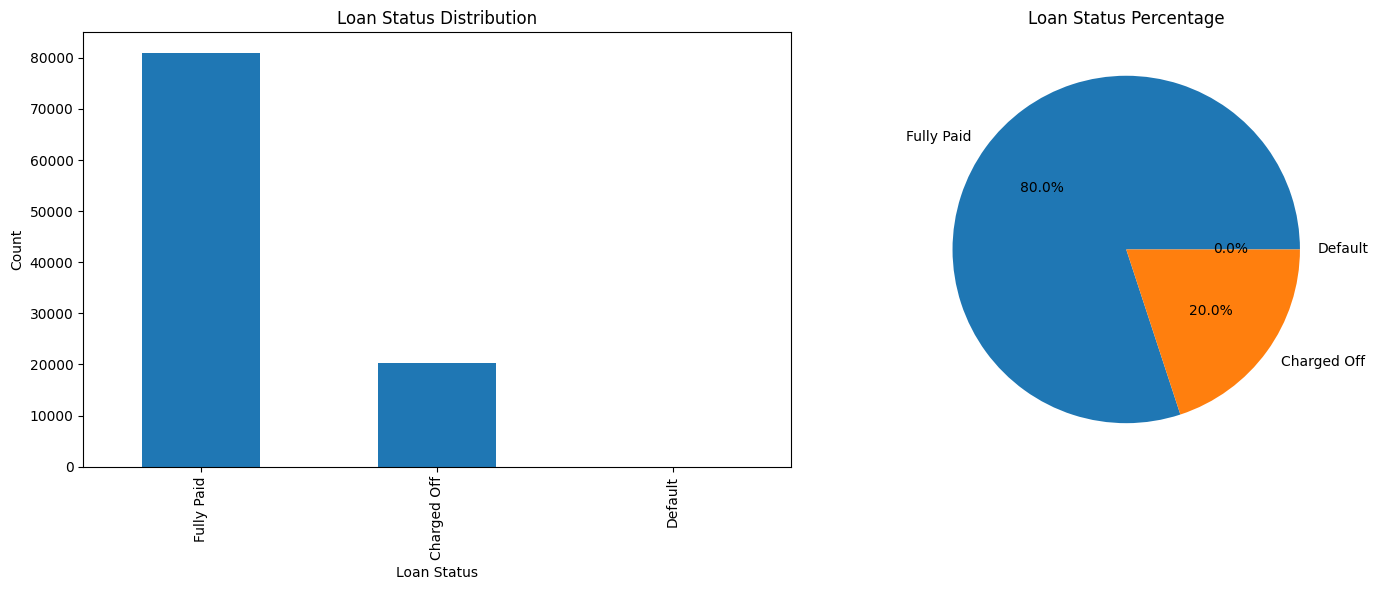


=== NUMERICAL FEATURES ANALYSIS ===
Numerical columns: 27
           loan_amnt    funded_amnt       int_rate    installment  \
count  101140.000000  101140.000000  101140.000000  101140.000000   
mean    14429.072078   14429.072078      11.976002     431.491467   
std      8603.865314    8603.865314       4.150317     254.107972   
min      1000.000000    1000.000000       5.320000      14.770000   
25%      8000.000000    8000.000000       8.380000     246.620000   
50%     12000.000000   12000.000000      11.530000     371.960000   
75%     20000.000000   20000.000000      14.330000     573.830000   
max     35000.000000   35000.000000      28.990000    1445.460000   

         annual_inc            dti    delinq_2yrs  inq_last_6mths  \
count  1.011400e+05  101140.000000  101140.000000   101140.000000   
mean   7.795858e+04      19.002187       0.351948        0.599080   
std    8.879191e+04       9.568368       0.932479        0.886973   
min    1.200000e+03       0.000000       0.

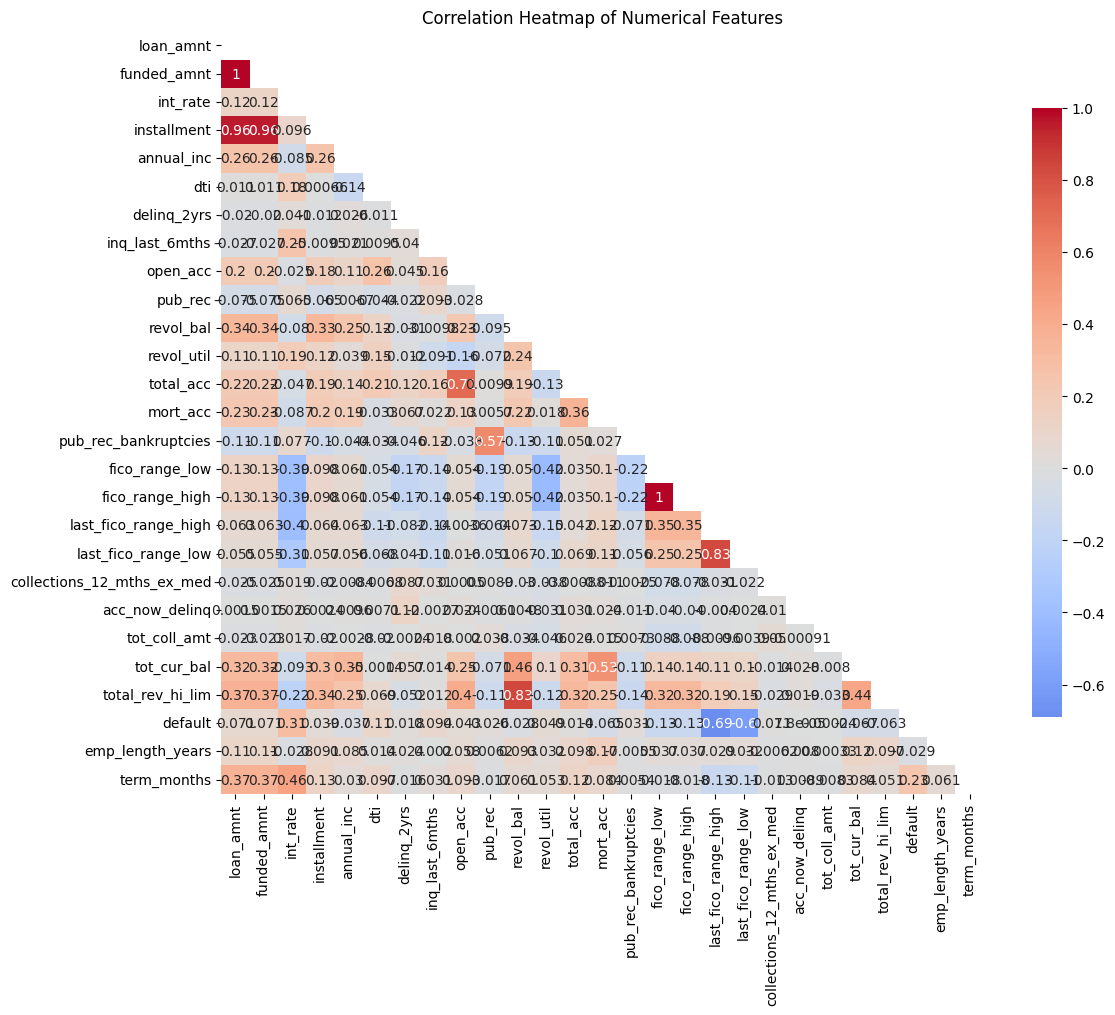


=== CATEGORICAL FEATURES ANALYSIS ===
Categorical columns: 12

term - Top 10 values:
term
36 months    78036
60 months    23104
Name: count, dtype: int64

grade - Top 10 values:
grade
B    31971
C    28119
A    19656
D    12746
E     6449
F     1791
G      408
Name: count, dtype: int64

sub_grade - Top 10 values:
sub_grade
B3    6697
B4    6662
C1    6425
B5    6408
B2    6249
C2    6036
B1    5955
C4    5717
C3    5683
A5    5477
Name: count, dtype: int64

emp_title - Top 10 values:
emp_title
Teacher             1915
Manager             1669
Owner                993
Registered Nurse     817
RN                   773
Supervisor           747
Driver               642
Sales                616
Project Manager      564
Director             503
Name: count, dtype: int64

emp_length - Top 10 values:
emp_length
10+ years    33600
2 years       8856
< 1 year      8831
3 years       8151
1 year        6653
5 years       6022
4 years       5825
8 years       5134
6 years       3965
9 years      

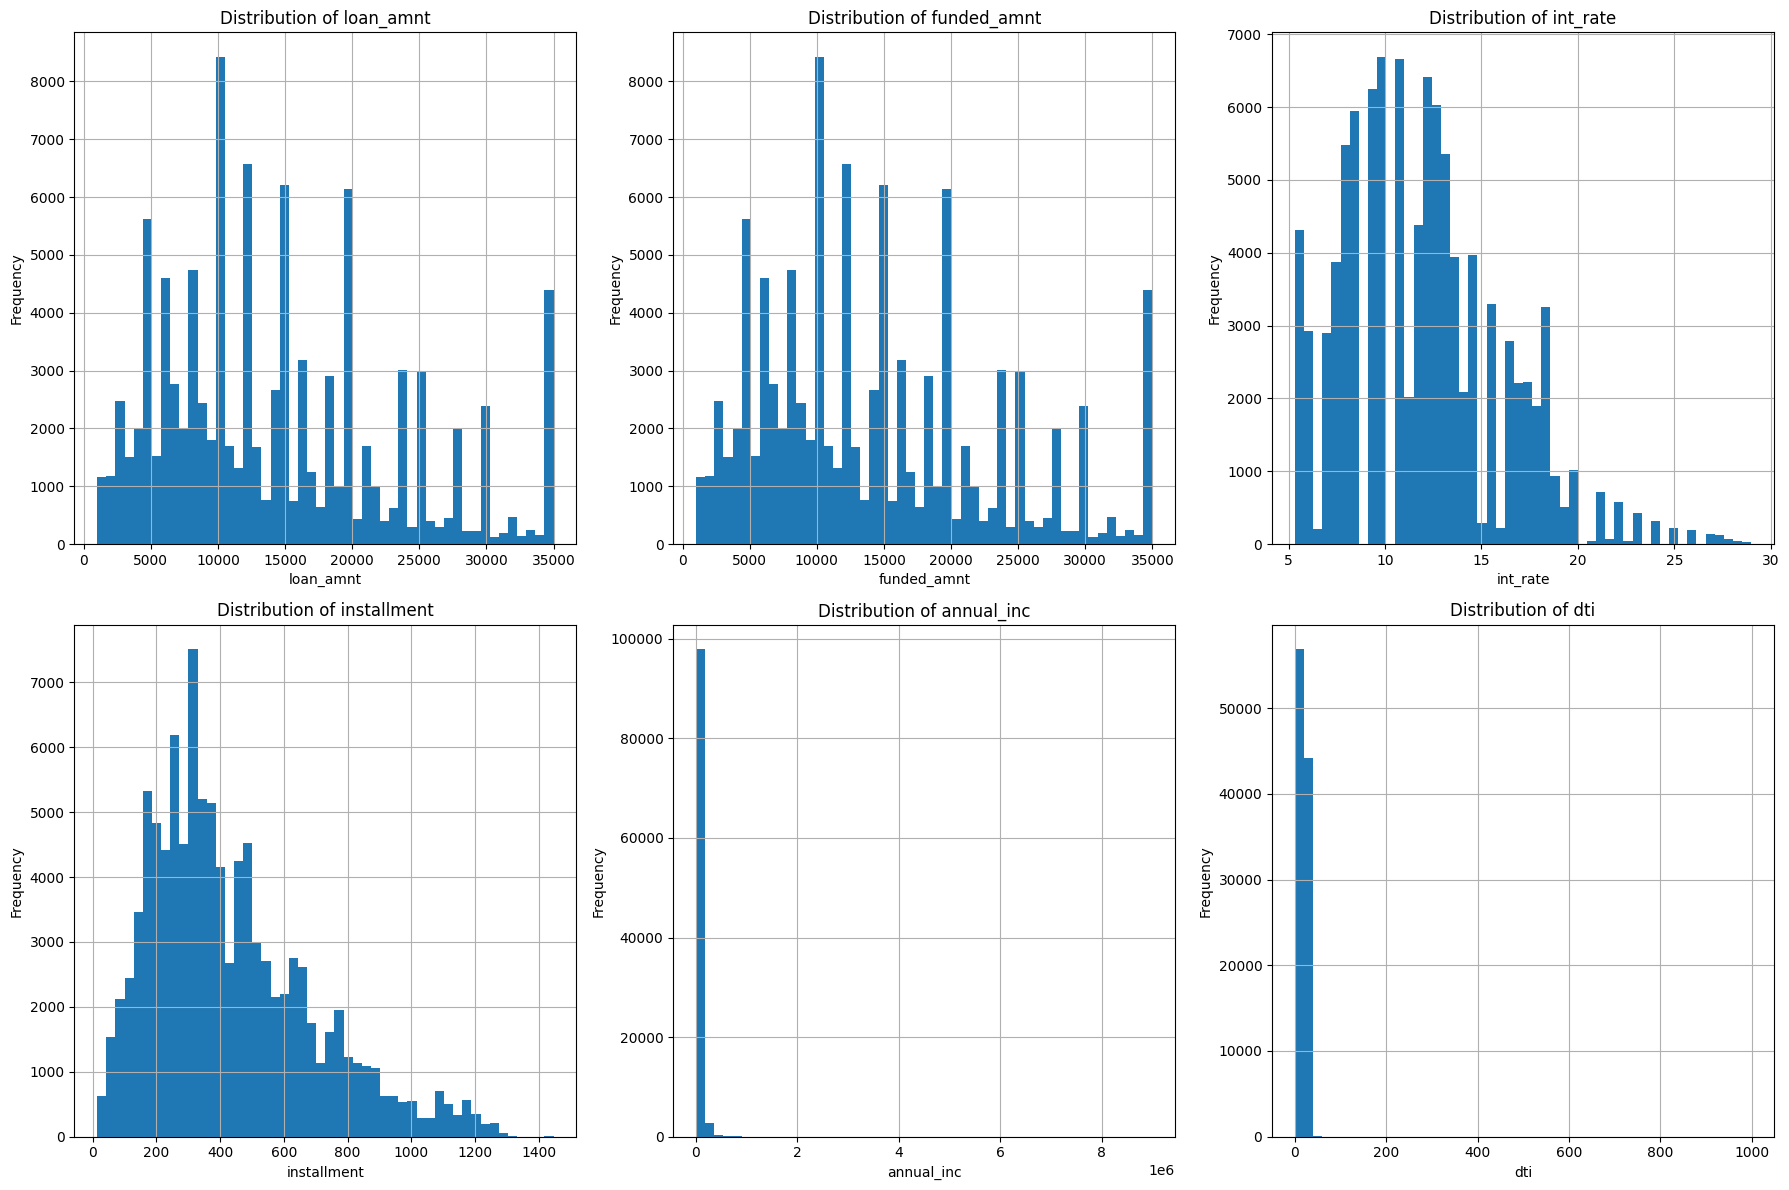

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
df = pd.read_csv('/content/drive/MyDrive/cleaned_credit_data.csv')

def comprehensive_eda(df):
    """Comprehensive EDA for credit risk data"""

    print("=== DATASET OVERVIEW ===")
    print(f"Shape: {df.shape}")
    print(f"\nData Types:\n{df.dtypes.value_counts()}")
    print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Missing values analysis
    print("\n=== MISSING VALUES ANALYSIS ===")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    }).sort_values('Missing Percentage', ascending=False)

    print(missing_df[missing_df['Missing Percentage'] > 0])

    # Target variable analysis (assuming 'loan_status' is target)
    if 'loan_status' in df.columns:
        print("\n=== TARGET VARIABLE ANALYSIS ===")
        target_counts = df['loan_status'].value_counts()
        print(target_counts)

        # Visualize target distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Count plot
        target_counts.plot(kind='bar', ax=ax1)
        ax1.set_title('Loan Status Distribution')
        ax1.set_xlabel('Loan Status')
        ax1.set_ylabel('Count')

        # Pie chart
        ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%')
        ax2.set_title('Loan Status Percentage')

        plt.tight_layout()
        plt.show()

    # Numerical features analysis
    print("\n=== NUMERICAL FEATURES ANALYSIS ===")
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if len(numerical_cols) > 0:
        print(f"Numerical columns: {len(numerical_cols)}")
        print(df[numerical_cols].describe())

        # Correlation heatmap
        plt.figure(figsize=(12, 10))
        correlation_matrix = df[numerical_cols].corr()
        mask = np.triu(correlation_matrix.corr())
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, mask=mask, cbar_kws={'shrink': 0.8})
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.show()

    # Categorical features analysis
    print("\n=== CATEGORICAL FEATURES ANALYSIS ===")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(categorical_cols) > 0:
        print(f"Categorical columns: {len(categorical_cols)}")

        # Top categories for each categorical column
        for col in categorical_cols[:5]:  # Show first 5
            print(f"\n{col} - Top 10 values:")
            print(df[col].value_counts().head(10))

    # Distribution plots for key numerical features
    if len(numerical_cols) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        for i, col in enumerate(numerical_cols[:6]):
            df[col].hist(bins=50, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    return df

# Perform EDA
df_analyzed = comprehensive_eda(df)